This does not have a reward for each individual turn. Just plays out d cycles of turns and uses the evaluation function at end.

In [3]:
from utils.game_map_class import GameMap
from utils.game_team_class import GameTeam
from utils.strategy_class import Strategy, RandomStrategy, RuleOfThumbStrategy
from utils.map_setup_functions import setGameBoardRandom, initializeFullRiskMap
from utils.heuristics import BST_Heuristic

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
import copy

In [6]:
def rollout_lookahead(team,riskMap,d,discount):
    '''Returns the best action according to lookahead with rollouts'''
    return greedy(team,riskMap,d,discount)[0]

In [7]:
def greedy(team,riskMap,d,discount):
    '''Greedily looks through all possible actions and determines the value of each from the current state
    using lookahead with rollouts. Returns action with maximum value and the value itself'''
    possible_attackers = team.getPossibleAttacks()
    print(possible_attackers)
    lookahead_list = []
    for attacker in possible_attackers:
        for defender in possible_attackers[attacker]:
            action = (attacker,defender)
            u = lookahead(discount,riskMap,action,d)
            lookahead_list.append((action,u))
    print(lookahead_list)
    if len(lookahead_list) == 0:
        return (None,None)
    return max(lookahead_list, key = lambda x: x[1])

In [8]:
def lookahead(discount,riskMap,action,d):
    ''' Computes successor states and probabilities of these successor states given the current riskMap
    
    Then for each of these successor states performs a rollout to get a value that that successor state and 
    multiplies it by the probability of that successor state. Takes the sum of those values and multiplies it
    by the discount factor to return the value of that function.
    '''
    
    # Gets basic information about current state of play
    attacking_territory, defending_territory = action
    num_attackers = riskMap.getTroops(attacking_territory)
    num_defenders = riskMap.getTroops(defending_territory)
    
    # Computes successor states and transition probabilities
    succ_state_probs = {}
    compute_succ_state_prob(1,num_attackers,num_defenders,succ_state_probs)
    
    sum_successors = 0
    for succ in succ_state_probs:
        
        # Sets up successor state
        sp = copy.deepcopy(riskMap)
        attacking_team = sp.getTeam(attacking_territory)
        defending_team = sp.getTeam(defending_territory)
        set_up_sp(sp,succ,attacking_team,defending_team,attacking_territory,defending_territory)
        
        # Gets value of successor state via rollout and multiplies by the transition probability to add to sum
        prob = succ_state_probs[succ]
        sum_successors += prob*rollout(discount,sp,d,attacking_team,defending_team)
        
    return discount*sum_successors

In [9]:
def compute_succ_state_prob(prob,num_attackers,num_defenders,succ_state_probs):
    """This recursive function run to completion is meant to take prob = 1 and a number of attackers
    and defenders for a battle and update the succ_state_probs dictionary with the possible outcomes mapped
    to their respective probabilities."""
    if num_attackers == 0 or num_attackers == 1 or num_defenders == 0:
        if (num_attackers,num_defenders) in succ_state_probs:
            succ_state_probs[(num_attackers,num_defenders)] += prob
        else:
            succ_state_probs[(num_attackers,num_defenders)] = prob
    if num_attackers == 2 and num_defenders == 1:
        compute_succ_state_prob(prob*5/12,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*7/12,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 3 and num_defenders == 1:
        compute_succ_state_prob(prob*125/216,num_attackers,num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*91/216,num_attackers - 1,num_defenders,succ_state_probs)
    if num_attackers > 3 and num_defenders == 1:
        compute_succ_state_prob(prob*95/144,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*49/144,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 2 and num_defenders > 1:
        compute_succ_state_prob(prob*55/216,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*161/216,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 3 and num_defenders > 1:
        compute_succ_state_prob(prob*295/1296,num_attackers, num_defenders - 2,succ_state_probs)
        compute_succ_state_prob(prob*35/108,num_attackers - 1, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*581/1296,num_attackers - 2, num_defenders,succ_state_probs)
    if num_attackers > 3 and num_defenders > 1:
        compute_succ_state_prob(prob*1445/3888,num_attackers, num_defenders - 2,succ_state_probs)
        compute_succ_state_prob(prob*2611/7776,num_attackers - 1, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*2275/7776,num_attackers - 2, num_defenders,succ_state_probs)

In [10]:
def set_up_sp(sp,succ,attacking_team,defending_team,attacking_territory,defending_territory):
    '''Sets up a successor state'''
    succ_num_attackers, succ_num_defenders = succ

    attacking_team.setTroops(attacking_territory, succ_num_attackers)
    defending_team.setTroops(defending_territory, succ_num_defenders)

    if succ_num_defenders == 0:

        # Declare the territory to the attacking team! 
        sp.setTeam(defending_territory, attacking_team)
        # Assign the territory to the attacking team
        attacking_team.addTerritory(defending_territory)
        defending_team.removeTerritory(defending_territory)

        # Move all but one remaining attacking troops to the territory
        attacking_team.moveTroops(attacking_territory, defending_territory, succ_num_attackers - 1)

In [18]:
def rollout(discount,sp,d,my_team,opponent):
    '''Rolls out using a stochastic policy (this is encoded in the strategy of my_team itself) against player. 
    Repeats rounds of turns to depth. If my_team wins, the reward is 100. If the opponent wins, the reward is 0.
    Otherwise, at the end of the rollout, we use the BST heuristic for both teams and the reward. We see what percentage
    of BTS between the two teams is attributed to the opponent (would be good for my_team) and use that as the reward'''
    ret = 0
    end_reached = False
    for t in range(d):
        if my_team.hasTeamWon():
            r = 100
            return (discount**t)*r
        opponent.playTurn()
        if opponent.hasTeamWon():
            r = -1
            return (discount**t)*r
        my_team.playTurn()
    if my_team.hasTeamWon():
        r = 100
        return (discount**(d-1))*r
    elif opponent.hasTeamWon():
        r = -1
        return (discount**(d-1))*r
    else:
        print(BST_Heuristic(my_team,sp))
        BST_my_team_sum = sum(list(BST_Heuristic(my_team,sp).values()))
        BST_opponent_sum = sum(list(BST_Heuristic(opponent,sp).values()))
        r = 100*BST_opponent_sum/(BST_my_team_sum+BST_opponent_sum)
        return (discount**(d-1))*r

In [12]:
full_risk_map = initializeFullRiskMap()
team_names = ["rollout_team","rollout_opponent"]
team_strategies = [RandomStrategy,RuleOfThumbStrategy]
risk_map, teams = setGameBoardRandom(team_names, full_risk_map, team_strategies)
teams[1].getPossibleAttacks()

{}

Adding 1 to Eastern United States!
Adding 1 to Western United States!
Adding 1 to Irkutsk!
Adding 1 to Eastern United States!
Adding 1 to Mongolia!
Adding 1 to Alaska!
Adding 1 to Western United States!
('Alaska', ['North West Territory'])
('Alaska', 'North West Territory')
Team rollout_team declares attack on Team rollout_opponent from Alaska to North West Territory
Attacking_dice:  [6]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Eastern United States', ['Quebec'])
('Eastern United States', 'Quebec')
Team rollout_team declares attack on Team rollout_opponent from Eastern United States to Quebec
Attacking_dice:  [2, 1]
Defending_dice:  [3]
[False]
Attacking Troops Left:  2
Defending Troops Left:  1
Attacking_dice:  [5]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Irkutsk', ['Siberia'])
('Irkutsk', 'Siberia')
Team rollout_team declares attack on Team rollout_opponent from Irkutsk to Siberia
Attacking_dice:  [5]

/Users/janieboettcher/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


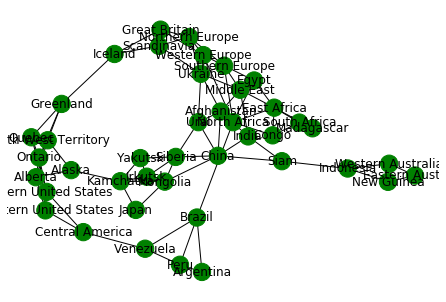

In [13]:
curr_team = teams[0]
defending_team = teams[1]
counter = 0
while len(teams[0].getPossibleAttacks())==0:
    curr_team.playTurn()
    curr_team_temp = curr_team
    curr_team = defending_team
    defending_team = curr_team_temp
    color_map = risk_map.getTeamColorMap()
    nx.draw(risk_map.graph, node_color = color_map, with_labels=True)
    plt.show()
    counter += 1

In [14]:
teams[0].getPossibleAttacks()

{'Mongolia': ['Siberia', 'Japan']}

In [19]:
rollout_lookahead(teams[0],risk_map,30,.95)

{'Mongolia': ['Siberia', 'Japan']}
Adding 6 to East Africa!
('East Africa', 'Egypt')
Team rollout_opponent declares attack on Team rollout_team from East Africa to Egypt
Attacking_dice:  [4, 2, 1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  6
Defending Troops Left:  1
Attacking_dice:  [5, 3, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  5
Defending Troops Left:  1
Attacking_dice:  [4, 2, 1]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
('Egypt', 'North Africa')
Team rollout_opponent declares attack on Team rollout_team from Egypt to North Africa
Attacking_dice:  [5, 4, 2]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  4
Defending Troops Left:  0
('North Africa', 'Congo')
Team rollout_opponent declares attack on Team rollout_team from North Africa to Congo
Attacking_dice:  [5, 3]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
Adding 1 to North West Territory!
Adding 1 to Irkutsk!
Adding 1 to Si

Attacking_dice:  [5, 3, 2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  3
Defending Troops Left:  1
Attacking_dice:  [4, 3]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Venezuela', ['Central America'])
('Venezuela', 'Central America')
Team rollout_team declares attack on Team rollout_opponent from Venezuela to Central America
Attacking_dice:  [1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Brazil', ['North Africa'])
Adding 12 to North Africa!
('North Africa', 'Brazil')
Team rollout_opponent declares attack on Team rollout_team from North Africa to Brazil
Attacking_dice:  [4, 3, 1]
Defending_dice:  [4, 1]
[False  True]
Attacking Troops Left:  12
Defending Troops Left:  2
Attacking_dice:  [5, 4, 2]
Defending_dice:  [6, 4]
[False False]
Attacking Troops Left:  10
Defending Troops Left:  2
Attacking_dice:  [4, 2, 1]
Defending_dice:  [5, 1]
[False  True]
Attacking Troops Left:  9
Defending Troops Left:  1
A

('South Africa', 'Congo')
Team rollout_opponent declares attack on Team rollout_team from South Africa to Congo
Attacking_dice:  [6, 4, 3]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  8
Defending Troops Left:  0
('Congo', 'North Africa')
Team rollout_opponent declares attack on Team rollout_team from Congo to North Africa
Attacking_dice:  [6, 3, 2]
Defending_dice:  [3, 1]
[ True  True]
Attacking Troops Left:  7
Defending Troops Left:  0
Adding 1 to New Guinea!
Adding 1 to Indonesia!
Adding 1 to Venezuela!
('Venezuela', ['Brazil', 'Peru'])
('Venezuela', 'Peru')
Team rollout_team declares attack on Team rollout_opponent from Venezuela to Peru
Attacking_dice:  [4]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Indonesia', ['Siam'])
('Indonesia', 'Siam')
Team rollout_team declares attack on Team rollout_opponent from Indonesia to Siam
Attacking_dice:  [4]
Defending_dice:  [4]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
Adding 11 t

Team rollout_team declares attack on Team rollout_opponent from Alberta to Alaska
Attacking_dice:  [2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Western United States', ['Ontario', 'Eastern United States', 'Central America'])
('Western United States', 'Central America')
Team rollout_team declares attack on Team rollout_opponent from Western United States to Central America
Attacking_dice:  [4]
Defending_dice:  [5]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Brazil', ['Venezuela', 'Peru', 'North Africa'])
('Brazil', 'North Africa')
Team rollout_team declares attack on Team rollout_opponent from Brazil to North Africa
Attacking_dice:  [4, 3]
Defending_dice:  [5]
[False]
Attacking Troops Left:  2
Defending Troops Left:  1
Attacking_dice:  [6]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Southern Europe', ['Western Europe', 'Northern Europe', 'Ukraine', 'Middle East', 'Egypt'])
('Southern Europ

Defending_dice:  [1]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Quebec', ['Ontario', 'Greenland', 'Eastern United States'])
('Quebec', 'Greenland')
Team rollout_team declares attack on Team rollout_opponent from Quebec to Greenland
Attacking_dice:  [4, 1]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('North Africa', ['Brazil', 'Western Europe', 'Southern Europe', 'East Africa', 'Congo'])
('North Africa', 'Congo')
Team rollout_team declares attack on Team rollout_opponent from North Africa to Congo
Attacking_dice:  [6, 2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Greenland', ['North West Territory', 'Ontario', 'Iceland'])
('Greenland', 'North West Territory')
Team rollout_team declares attack on Team rollout_opponent from Greenland to North West Territory
Attacking_dice:  [4]
Defending_dice:  [5]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Argentina', ['Brazil'])
Adding 7 to

Attacking Troops Left:  10
Defending Troops Left:  0
('Greenland', 'Quebec')
Team rollout_opponent declares attack on Team rollout_team from Greenland to Quebec
Attacking_dice:  [5, 2, 1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  8
Defending Troops Left:  1
Attacking_dice:  [3, 2, 1]
Defending_dice:  [3]
[False]
Attacking Troops Left:  7
Defending Troops Left:  1
Attacking_dice:  [6, 4, 2]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  7
Defending Troops Left:  0
Adding 1 to Central America!
Adding 1 to Eastern Australia!
Adding 1 to Indonesia!
Adding 1 to Western Australia!
('Indonesia', ['Siam'])
('Indonesia', 'Siam')
Team rollout_team declares attack on Team rollout_opponent from Indonesia to Siam
Attacking_dice:  [5]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Central America', ['Western United States', 'Eastern United States'])
('Central America', 'Western United States')
Team rollout_team declares attack on Team rollout_oppo

('Mongolia', 'Japan')

In [18]:
a = {1:2,2:3}
a.values()

dict_values([2, 3])